In [57]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
import openpyxl
import akshare as ak
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 5000
pd.options.display.float_format = lambda x: '%.5f' % x
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format='svg'
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [58]:
price=ak.stock_zh_a_hist(symbol='603444',period='daily',adjust='qfq',start_date='20221218',end_date='20250101')
price=price.drop(columns=['股票代码','最高','最低','成交量','成交额','振幅','换手率','涨跌额'])
price['MA10']=price['收盘'].rolling(window=10).mean()
price=price.drop(index=range(10)).reset_index().drop(columns='index')
initial_cash=100000.0
tax=0.00025
df=pd.DataFrame(columns=['日期','开盘','收盘','MA10','涨跌幅','可买','持仓','持有天数','交易信号','总市值','现金','策略收益率','股票收益率']
                ,index=range(len(price)))
df[['日期','开盘','收盘','涨跌幅','MA10']]=price[['日期','开盘','收盘','涨跌幅','MA10']]
df['持仓']=0
df['总市值']=0.0
df['现金']=initial_cash
df['策略收益率']=0.0
df['股票收益率']=0.0
df['交易信号']=0
df['持有天数']=0
df['总资产']=100000.0
df['可买']=0
for i in range(1,len(df)):
    df.loc[i,'可买']=((df.loc[i-1,'现金']/df.loc[i,'开盘'])//100)*100
    if df.loc[i-1,'收盘']<df.loc[i,'MA10'] and df.loc[i,'收盘']>=df.loc[i,'MA10']:
        df.loc[i,'交易信号']=1
    if df.loc[i-1,'持仓']>0:
        df.loc[i,'持有天数']=df.loc[i-1,'持有天数']+1
    if df.loc[i,'持有天数']==5:
        df.loc[i,'交易信号']=-1
    if i+1<len(df):
        buy=max(df.loc[i+1,'开盘']*df.loc[i,'可买']*tax,5)+df.loc[i+1,'开盘']*df.loc[i,'可买']
    else:
        buy=0
    if i-5 in range(len(df)):
        sell=df.loc[i,'收盘']*df.loc[i-5,'可买']-max(df.loc[i,'收盘']*df.loc[i-5,'可买']*tax,5)
    if df.loc[i-1,'交易信号']==1 and df.loc[i-1,'现金']>=buy and df.loc[i-1,'持仓']==0 :
        df.loc[i,'现金']=df.loc[i-1,'现金']-buy
        df.loc[i,'持仓']=df.loc[i-1,'持仓']+df.loc[i,'可买']
        df.loc[i,'持有天数']=1+df.loc[i-1,'持有天数']
    elif df.loc[i-1,'交易信号']==-1 and  df.loc[i-1,'持仓']>=df.loc[i-5,'可买']:
        df.loc[i,'现金']=df.loc[i-1,'现金']+sell
        df.loc[i,'持仓']=df.loc[i-1,'持仓']-df.loc[i-5,'可买']
        df.loc[i,'持有天数']=0
    else:
        df.loc[i,'现金']=df.loc[i-1,'现金']
        df.loc[i,'持仓']=df.loc[i-1,'持仓']
    df.loc[i,'总市值']=df.loc[i,'持仓']*df.loc[i,'收盘']
    df.loc[i,'总资产']=df.loc[i,'总市值']+df.loc[i,'现金']
    df.loc[i,'策略收益率']=(df.loc[i,'总资产']/initial_cash)-1
    df.loc[i,'股票收益率']=df.loc[i,'收盘']/df.loc[0,'收盘']-1


Text(0.5, 1.0, '603444吉比特：MA10上穿策略')

Text(0.5, 0, '时间/月（2023-2024）')

Text(0, 0.5, '收益率')

Text(19500, -0.5, '数据来源：akshare，不构成任何投资建议，仅供参考\n策略：股价MA10次日开盘买入100整数倍可买股，5日后卖出\n交易费率万2.5不免5(可更改)\n制作者：NPC雷神1')

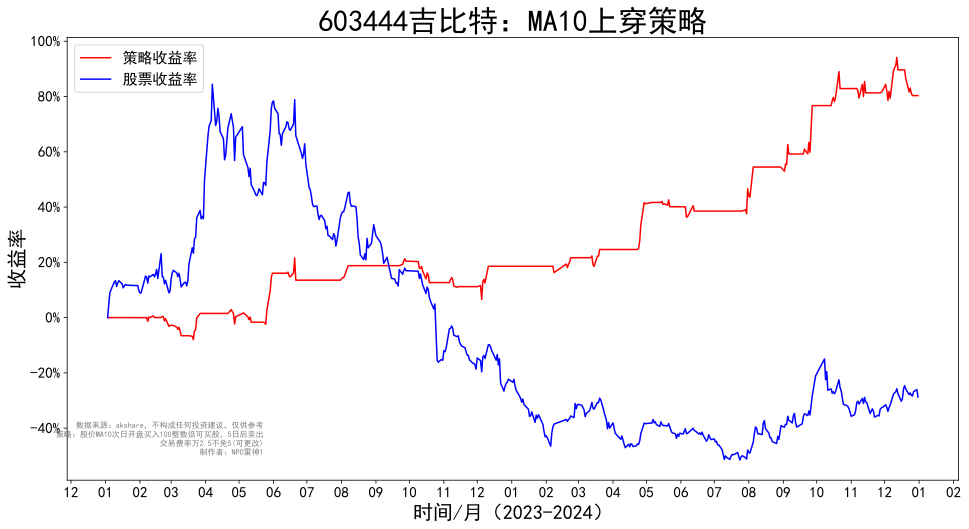

In [59]:
fig,ax1=plt.subplots(figsize=(16,8))
plt.plot(df['日期'],df['策略收益率'],color='r',label='策略收益率')
plt.plot(df['日期'],df['股票收益率'],color='b',label='股票收益率')
plt.title('603444吉比特：MA10上穿策略',fontsize=30)
plt.xlabel('时间/月（2023-2024）',fontsize=20)
plt.ylabel('收益率',fontsize=20)
plt.legend(fontsize=15)
plt.text(x=19500,y=-0.5,s='数据来源：akshare，不构成任何投资建议，仅供参考\n策略：股价MA10次日开盘买入100整数倍可买股，5日后卖出\n交易费率万2.5不免5(可更改)\n制作者：NPC雷神1',ha='right',va='bottom',fontsize=8,color='gray')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(1,decimals=0))
plt.tick_params(labelsize=15)
plt.savefig(r'E:/jupyter/plot/603444吉比特：MA10上穿策略.png')
plt.show()

#